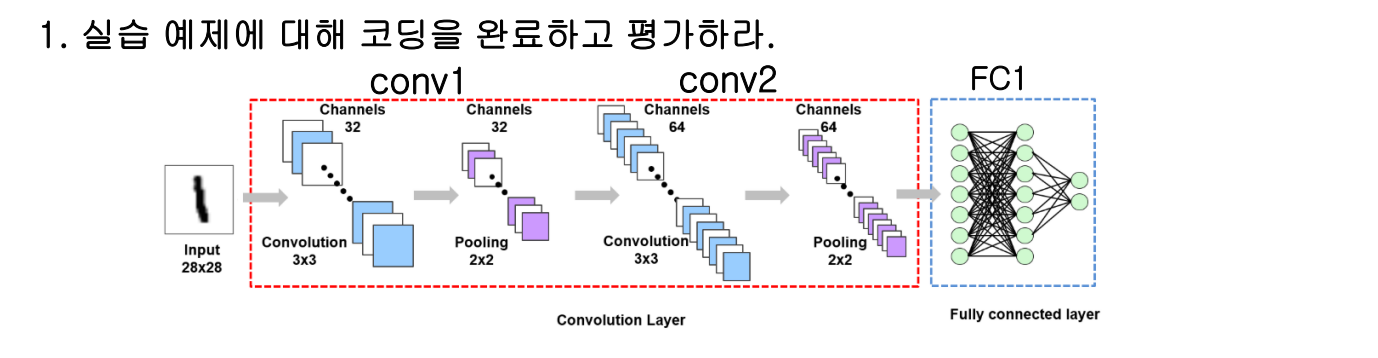

1. 데이터 로딩 및 전처리

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

mnist = tf.keras.datasets.mnist  # MNIST 손글씨 숫자 이미지 데이터셋 로드
(train_x, train_y), (test_x, test_y) = mnist.load_data() # 학습용과 테스트용 데이터 분리

train_x, test_x = train_x/255.0, test_x/255.0  # 정규화 (픽셀 0~255 -> 0~1)

train_x.shape

train_x = train_x.reshape((train_x.shape[0], 28,28,1))
test_x = test_x.reshape((test_x.shape[0],28,28,1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


2. 네트워크 구조 하이퍼파라미터 설정

In [ ]:
# input layer
input_h, input_w, input_ch = 28, 28, 1

# 1st convolution layer
k1_h, k1_w, k1_ch = 3, 3, 32  # conv1 filter 3x3, 출력채널 32
p1_h, p1_w = 2, 2             # max pooling 크기

# 2nd convolution layer
k2_h, k2_w, k2_ch = 3, 3, 64  # conv2 filter 3x3, 출력채널 64
p2_h, p2_w = 2, 2

# Fully connected : flatten the features (7x7x64)
conv_result_size = 7 * 7 * 64 # conv2 이후 feature map 크기
n_hidden = 100                # FC1 은닉 노드 수
n_output = 10                 # 출력 클래스 수 (0~9)

3. Variable 및 placeholder 정의

In [ ]:
# Kernel size : [kernel_height, kernel_width, input_ch, output_ch]
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # TensorFlow 1.x 방식 사용

# 가중치 초기화: 정규분포 사용
weights = {
    'conv1': tf.Variable(tf.random.normal([k1_h, k1_w, input_ch, k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_h, k2_w, k1_ch, k2_ch], stddev=0.1)),
    'hidden': tf.Variable(tf.random.normal([conv_result_size, n_hidden], stddev=0.1)),
    'output': tf.Variable(tf.random.normal([n_hidden, n_output], stddev=0.1))
}

# 바이어스 초기화
biases = {
    'conv1': tf.Variable(tf.random.normal([k1_ch], stddev=0.1)),
    'conv2': tf.Variable(tf.random.normal([k2_ch], stddev=0.1)),
    'hidden': tf.Variable(tf.random.normal([n_hidden], stddev=0.1)),
    'output': tf.Variable(tf.random.normal([n_output], stddev=0.1))
}

# input layer : [batch_size, image_height, image_width, channels]
# output layer : [batch_size, class_size]
x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch])  # 입력 이미지
y = tf.placeholder(tf.float32, [None, n_output])                    # 정답 (one-hot 벡터)

Instructions for updating:
non-resource variables are not supported in the long term


4. CNN 모델 정의

In [ ]:
# [batch, height, width, channels]
def net(x, weights, biases):
    # conv1 + ReLU + pooling
    conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    maxp1 = tf.nn.max_pool(conv1, ksize=[1, p1_h, p1_w, 1], strides=[1, p1_h, p1_w, 1], padding='VALID')

    # conv2 + ReLU + pooling
    conv2 = tf.nn.conv2d(maxp1, weights['conv2'], strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    maxp2 = tf.nn.max_pool(conv2, ksize=[1, p2_h, p2_w, 1], strides=[1, p2_h, p2_w, 1], padding='VALID')

    # Flatten
    maxp2_flatten = tf.reshape(maxp2, [-1, conv_result_size])  # (batch_size, 3136)

    # FC1 + ReLU
    hidden = tf.nn.relu(tf.add(tf.matmul(maxp2_flatten, weights['hidden']), biases['hidden']))

    # Output (logits)
    output = tf.add(tf.matmul(hidden, weights['output']), biases['output'])

    return output

5. 손실 함수 및 옵티마이저 정의

In [ ]:
# Loss function
pred = net(x, weights, biases)

# softmax + cross entropy → 분류용 손실 함수
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

# Adam Optimizer: 학습률 자동 조정 + 빠른 수렴
optm = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



6. 세션 생성 및 학습 루프

Iter: 0, Train Loss: 2.4801, Test Loss: 2.4664
Iter: 250, Train Loss: 0.7708, Test Loss: 0.5634
Iter: 500, Train Loss: 0.2528, Test Loss: 0.3079
Iter: 750, Train Loss: 0.1876, Test Loss: 0.2364
Iter: 1000, Train Loss: 0.1507, Test Loss: 0.5713
Iter: 1250, Train Loss: 0.0679, Test Loss: 0.3267
Iter: 1500, Train Loss: 0.1573, Test Loss: 0.1357
Iter: 1750, Train Loss: 0.3566, Test Loss: 0.3735
Iter: 2000, Train Loss: 0.0699, Test Loss: 0.0864
Iter: 2250, Train Loss: 0.2826, Test Loss: 0.1839


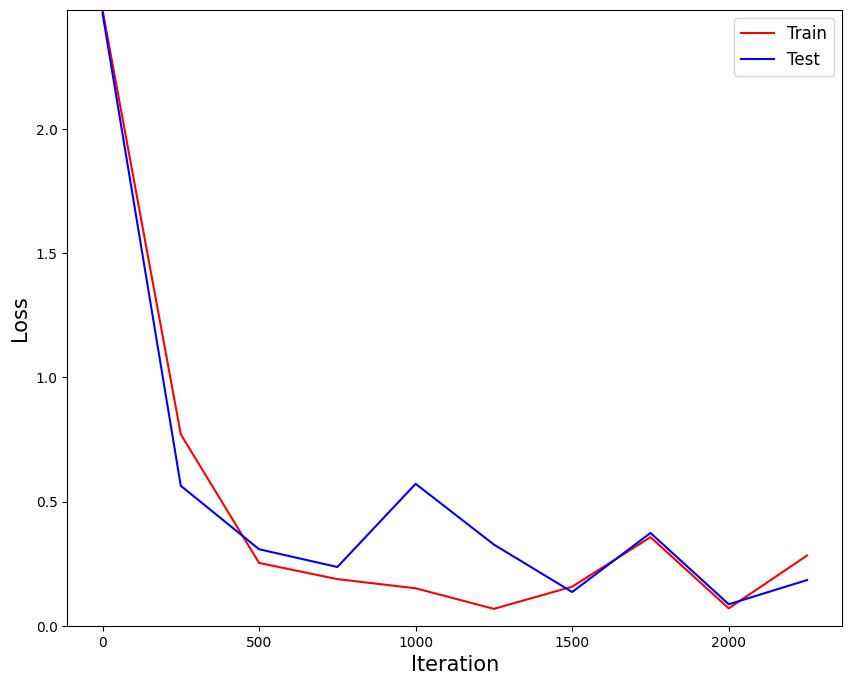

In [ ]:
# Optimization

# 세션 시작 및 변수 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 하이퍼파라미터
n_batch = 50     # 한 번에 학습할 데이터 수
n_iter = 2500    # 전체 반복 학습 횟수
n_prt = 250      # 손실 출력 주기

# 손실 기록용 리스트
loss_record_train = []
loss_record_test = []

# 학습 반복
for epoch in range(n_iter):
    # ----- 학습용 배치 추출 -----
    batch_indices = np.random.choice(train_x.shape[0], size=n_batch, replace=False)
    batch_x = train_x[batch_indices]
    batch_y = train_y[batch_indices]

    # 입력을 4D 텐서로 명시적 reshape
    batch_x = batch_x.reshape((n_batch, 28, 28, 1))
    # 레이블을 one-hot 인코딩
    batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=10)

    # 최적화 수행 (1회 학습)
    sess.run(optm, feed_dict={x: batch_x, y: batch_y})

    # ----- 일정 주기마다 손실 출력 -----
    if epoch % n_prt == 0:
        # 테스트용 배치 추출
        test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
        test_batch_x = test_x[test_batch_indices]
        test_batch_y = test_y[test_batch_indices]

        # 입력 reshape, 레이블 one-hot
        test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))
        test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

        # 손실 계산
        train_loss = sess.run(loss, feed_dict={x: batch_x, y: batch_y})
        test_loss = sess.run(loss, feed_dict={x: test_batch_x, y: test_batch_y})

        # 기록 저장
        loss_record_train.append(train_loss)
        loss_record_test.append(test_loss)

        # 콘솔 출력
        print("Iter: {}, Train Loss: {:.4f}, Test Loss: {:.4f}".format(epoch, train_loss, test_loss))

plt.figure(figsize = (10,8))
plt.plot(np.arange(len(loss_record_train))*n_prt, loss_record_train, 'r', label = 'Train')
plt.plot(np.arange(len(loss_record_test))*n_prt, loss_record_test, 'b', label = 'Test')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.legend(fontsize = 12)
plt.ylim([0, np.max(loss_record_train)])
plt.show()

7. 모델 평가(Accuracy 계산)

In [ ]:
# [Evaluation] 모델 정확도 평가

# 무작위로 테스트 데이터에서 배치 선택
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

# 입력 이미지를 명시적으로 reshape (4D 텐서)
test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))

# 정답 레이블을 one-hot 인코딩으로 변환
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

# 모델에 입력을 넣어 예측 결과(logits) 계산
my_pred = sess.run(pred, feed_dict={
    x: test_batch_x.reshape(-1, 28, 28, 1)  # 또는 그냥 test_batch_x도 OK
})

# 예측 확률 중 가장 큰 인덱스를 클래스 예측 결과로 변환
my_pred = np.argmax(my_pred, axis=1)

# 실제 정답(one-hot)도 argmax로 정수 레이블로 복원
labels = np.argmax(test_batch_y, axis=1)

# 예측 결과와 실제 레이블이 같은지 비교 → 정확도 계산
accr = np.mean(np.equal(my_pred, labels))

# 정확도를 %로 출력
print("Accuracy : {:.2f}%".format(accr * 100))

Accuracy : 98.00%


8. 단일 테스트 샘플 추론 및 시각화(예측 결과 확인)

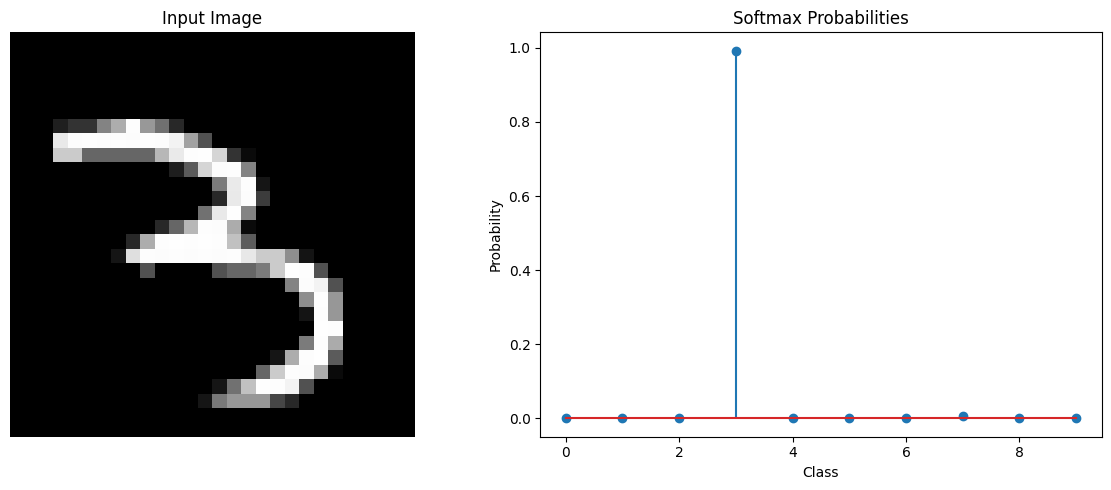

Prediction : 3
Probability : [0.   0.   0.   0.99 0.   0.   0.   0.01 0.   0.  ]


In [26]:
# Get a random batch of test data (n_batch = 1 for single image prediction)
n_batch = 1
test_batch_indices = np.random.choice(test_x.shape[0], size=n_batch, replace=False)
test_batch_x = test_x[test_batch_indices]
test_batch_y = test_y[test_batch_indices]

# 명시적으로 reshape하여 4D 텐서로 만듦 (1장 이미지)
test_batch_x = test_batch_x.reshape((n_batch, input_h, input_w, input_ch))

# 레이블을 one-hot 인코딩으로 변환
test_batch_y = tf.keras.utils.to_categorical(test_batch_y, num_classes=10)

# 모델 예측: softmax 확률 출력
logits = sess.run(tf.nn.softmax(pred), feed_dict={
    x: test_batch_x.reshape(-1, 28, 28, 1)  # 또는 그냥 test_batch_x
})

# 확률 벡터에서 가장 큰 값의 인덱스를 추출 → 예측 클래스
predict = np.argmax(logits)

# 시각화: 테스트 이미지 + softmax 확률 막대그래프
plt.figure(figsize=(12, 5))

# 왼쪽: 입력 이미지
plt.subplot(1, 2, 1)
plt.imshow(test_batch_x.reshape(28, 28), cmap='gray')
plt.title("Input Image")
plt.axis('off')

# 오른쪽: softmax 확률 분포
plt.subplot(1, 2, 2)
plt.stem(logits.ravel())  # 확률값 벡터를 막대그래프로
plt.title("Softmax Probabilities")
plt.xlabel("Class")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()

# 예측 결과 출력
np.set_printoptions(precision=2, suppress=True)  # 출력 형식: 소수점 2자리, 지수표현 방지
print('Prediction : {}'.format(predict))
print('Probability : {}'.format(logits.ravel()))